<a href="https://colab.research.google.com/github/aulphin/FS_Attack-RISE/blob/main/exp_Grad_cam%2B_FS_atk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/FS_Attack-main

/content/drive/MyDrive/FS_Attack-main


In [3]:
import argparse
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import json

In [4]:
from nn.utils import clamp

no display found. Using non-interactive Agg backend


### 基本設定
### Basic Configuration

### 讀取圖片 Read Pictures

In [5]:
case = '0'
exp_method = 'lrp' #  choices=['lrp', 'guided_backprop', 'gradient', 'integrated_grad', 'pattern_attribution', 'grad_times_input']

img = 'tmp_image/'+case+'.jpeg'

lr = 0.0002
cuda = True
output_dir = 'temp_result/'
beta_growth = True
prefactors = [1e4, 1e10, 1e-4] # 4 10 -4
device = torch.device("cuda" if cuda else "cpu")

### 讀取model

In [6]:
import torch
import torchvision.models as models
# Load a pre-trained ResNet50 model
model = models.resnet50(weights=True)
model.eval()  # Set to evaluation mode
model.to(device)  # Move the model to the GPU if available
model = model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from torchvision import transforms
from PIL import Image

# Define the preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image directly with PIL
img_path = 'tmp_image/0.jpeg'  # Adjust the path if needed
img = Image.open(img_path).convert('RGB')  # Ensure it's RGB mode

# Apply the preprocessing transformations
img_tensor = preprocess(img).unsqueeze(0)


In [8]:
x_adv = img_tensor.clone().detach().requires_grad_()

In [9]:
data_mean = np.array([0.485, 0.456, 0.406])
data_std = np.array([0.229, 0.224, 0.225])


### 先用實驗模型預測單張樣本
First use the experimental model to predict a single sample

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Move the input tensor to the same device as the model
img_tensor = img_tensor.to(device)

# Now you can perform the forward pass
predictions = model(img_tensor)


In [11]:
# predictions = model(img_tensor)
predictions = predictions.cpu().detach().numpy()
prediction_class = np.argmax(predictions[0])

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 236
origin_prediction_class = prediction_class
#im = im_orig.astype(np.float32)
#print('im: ',im.shape, type(im)) # im:  (299, 299, 3) <class 'numpy.ndarray'>
print('ori_image')
value_sort = np.sort(predictions[0])[::-1]
print(value_sort[:2][0], value_sort[:2][1])
score_diff = value_sort[:2][0] - value_sort[:2][1]
print('dump score diff:',score_diff)

Prediction class: 98
ori_image
18.065218 8.605768
dump score diff: 9.45945


In [12]:
value_sort = np.sort(predictions[0])[::-1]
index_sort = np.argsort(predictions[0])[::-1]
for i in range(5):
    print('label: ',index_sort[:5][i], ' score: ',value_sort[:5][i])

label:  98  score:  18.065218
label:  97  score:  8.605768
label:  141  score:  8.406608
label:  137  score:  7.8195214
label:  99  score:  7.42487


Produce its explanation using gradcam

In [13]:
from collections import defaultdict

In [14]:
def get_center_attack_matrix(x, y, r, org_expl, L):
    exp_list = org_expl.flatten()
    exp_list_sort, exp_list_sort_idx = exp_list.sort(descending=True)
    mtx = np.zeros((L, L))
    counter_dict = defaultdict(int)
    counter_dict_sum = defaultdict(int)

    # Calculate distance from target (x, y)
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x) + np.abs(j - y)
            counter_dict[n1] = counter_dict[n1] + 1

    max_n1 = max(x + y, L - x + L - y)

    for i in range(max_n1):
        if i == 0:
            counter_dict_sum[i] = 1
        else:
            counter_dict_sum[i] = counter_dict[i] + counter_dict_sum[i - 1]

    # Populate the target matrix
    for i in range(L):
        for j in range(L):
            n1 = np.abs(i - x) + np.abs(j - y)
            if n1 == 0:
                mtx[i, j] = exp_list_sort[0]
            elif n1 == 1:
                mtx[i, j] = exp_list_sort[1]
            elif n1 < r:
                # Add a boundary check for index access
                if counter_dict_sum[n1 - 1] < len(exp_list_sort):
                    mtx[i, j] = exp_list_sort[counter_dict_sum[n1 - 1]]
                else:
                    mtx[i, j] = exp_list_sort[-1]  # Default to the last element if index out of bounds
            else:
                mtx[i, j] = -exp_list_sort[counter_dict_sum[max_n1 + 1] if max_n1 + 1 < len(exp_list_sort) else -1]

    return mtx


 gradcam method

In [31]:
import torch
import torch.nn.functional as F

def get_grad_cam(model, img_tensor, target_layer, pred_class=None):
    """
    Compute Grad-CAM heatmap for the given image tensor and model, returning the heatmap as a PyTorch tensor.
    """
    # Ensure the input tensor requires gradients
    img_tensor.requires_grad = True
    img_tensor = img_tensor.to(device)

    # Forward pass through the model
    output = model(img_tensor)

    # If pred_class is not provided, use the model's predicted class
    if pred_class is None:
        pred_class = output.argmax(dim=1).item()

    # Lists to store activations and gradients
    activations = []
    gradients = []

    # Hooks to capture activations and gradients
    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])


    target_layer.register_forward_hook(forward_hook)
    target_layer.register_full_backward_hook(backward_hook)

    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    model.zero_grad()
    output[:, pred_class].backward()


   # Compute the weights (shape: [2048])
    weights = torch.mean(gradients[0], dim=[2, 3])


     # Compute the Grad-CAM heatmap
    heatmap = torch.sum(weights.view(-1, 1, 1) * activations[0], dim=1).squeeze()

    # After computing the heatmap
    heatmap = torch.maximum(heatmap, torch.tensor(0.0, device=heatmap.device))  # ReLU operation

    # Ensure the heatmap is not empty before normalizing
    if heatmap.max() > 0:
       heatmap /= heatmap.max()

    # Resize the heatmap to 224x224
    heatmap_resized = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)

     # The shape of heatmap_resized will now be [1, 1, 224, 224]. Squeeze the channel dimension to make it [1, 224, 224]
    orig_expl = heatmap_resized.squeeze(1)  # Shape will be [1, 224, 224]


    # Softmax for accuracy
    acc = F.softmax(output, dim=1)

    # Return the heatmap as a tensor, accuracy tensor, and predicted class index
    return orig_expl, acc, pred_class


In [32]:
# Call the get_grad_cam function to compute the Grad-CAM heatmap
orig_expl, orig_acc, class_idx = get_grad_cam(model, img_tensor, model.layer4[-1])


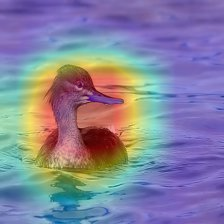

In [33]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow


# Convert img_tensor to numpy and unnormalize
img_np = img_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()  # Shape: (224, 224, 3)
img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Unnormalize
img_np = np.clip(img_np, 0, 1)  # Clip values to be between 0 and 1

# Resize the heatmap (orig_expl) to match the size of the image
heatmap_resized = cv2.resize(orig_expl.squeeze(0).cpu().detach().numpy(), (img_np.shape[1], img_np.shape[0]))  # Shape: (224, 224)

# Ensure heatmap is a 2D single-channel array and scale it to 0-255
heatmap_resized = np.uint8(255 * heatmap_resized)  # Convert heatmap to uint8

# Apply colormap to the heatmap
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)  # Shape: (224, 224, 3)

# Overlay the heatmap on the original image
superimposed_img = cv2.addWeighted(np.uint8(255 * img_np), 0.6, heatmap_colored, 0.4, 0)

# Display the result
cv2_imshow(superimposed_img)


In [34]:
# target attack
target_mtx = get_center_attack_matrix(200, 200, 35, orig_expl, 224)
target_mtx_torch = torch.tensor(target_mtx)
target_mtx_torch = target_mtx_torch.view(1,224,224)
target_mtx_torch = target_mtx_torch.to(device)
target_mtx_torch = target_mtx_torch.float()
#target_mtx_torch = torch.tensor(target_mtx).squeeze(0).to(device).float()  # Shape [1, 1, 224, 224]


optimizer = torch.optim.Adam([x_adv], lr=lr)

In [35]:
print(target_mtx_torch.shape)
print(orig_expl.shape)

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


### 攻擊開始
### Attack begins

Experimenting 2 cell

In [36]:
num_iter = 100
torch.autograd.set_detect_anomaly(True)

In [37]:
total_loss_list = []
epoch_exp = []
L1_score = []
L2_score = []
L3_score = []
L4_score = []
L5_score = []

early_stop_epoch = 0
mode_2_loss = False
EARLY_STOP = True #False
for i in range(num_iter):

    optimizer.zero_grad()

    # calculate loss
    adv_expl, adv_acc, class_idx = get_grad_cam(model, x_adv, model.layer4[-1])

    loss_center = F.mse_loss(adv_expl, target_mtx_torch)
    loss_output = F.mse_loss(adv_acc[0][prediction_class], orig_acc[0][prediction_class].detach())

    if mode_2_loss:
        total_loss = prefactors[0]*loss_output + prefactors[1]*loss_center
    else:
        total_loss = prefactors[0]*loss_output + prefactors[1]*loss_center

    total_loss_list.append(total_loss.item())
    #x_tmp = x_adv
    x_tmp = x_adv.clone().detach().requires_grad_(True)
    # update adversarial example
    total_loss.backward(retain_graph=True)
    optimizer.step()
    predictions = model(x_adv)
    predictions = predictions.cpu().detach().numpy()
    if (value_sort[:2][0] - value_sort[:2][1]) < 1 :
        mode_2_loss = True
    #print(i,predictions[0][prediction_class], value_sort[:2][0], value_sort[:2][1])
    L1_score.append(predictions[0][index_sort[:5][0]])
    L2_score.append(predictions[0][index_sort[:5][1]])
    L3_score.append(predictions[0][index_sort[:5][2]])
    L4_score.append(predictions[0][index_sort[:5][3]])
    L5_score.append(predictions[0][index_sort[:5][4]])
    prediction_class_tmp = np.argmax(predictions[0])
    if(prediction_class != prediction_class_tmp):
        print(i,'early done')
        early_stop_epoch = i
        if EARLY_STOP == True:
            x_adv = x_tmp
            break

    #x_adv.data = clamp(x_adv.data, data_mean, data_std)
    x_adv_clamped = clamp(x_adv, data_mean, data_std)
    x_adv = x_adv_clamped.clone().detach().requires_grad_(True)
    if i == 1:
        print("Iteration {}: Total Loss: {}, Gini Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_center.item(), loss_output.item()))
    #print("Iteration {}: Total Loss: {}, Expl Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_expl.item(), loss_output.item()))

    if (i+1)%50 == 0:
        print("Iteration {}: Total Loss: {}, Gini Loss: {}, Output Loss: {}".format(i, total_loss.item(), loss_center.item(), loss_output.item()))
        epoch_exp.append(adv_expl)



/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:768: UserWarning: Error detected in MaxBackward1. Traceback of forward call that caused the error:
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/usr/lib/pyt

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [7, 7]], which is output 0 of DivBackward0, is at version 1; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

# #############################upto this , we are doing ################################################################